# Custom MobileNet

In [1]:
print ("Bismillah")
# https://www.kaggle.com/sshikamaru/car-object-detection

Bismillah


# Kaggle

In [2]:
#installing required libraries
!pip install -q kaggle

#uploading json file downloaded from kaggle
from google.colab import files
files.upload()

{}

In [3]:
#copying json file to the right directory
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
#giving read write access
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# download kaggle dataset
!kaggle datasets download -d sshikamaru/car-object-detection

 98% 110M/112M [00:00<00:00, 107MB/s]  
100% 112M/112M [00:00<00:00, 135MB/s]


In [ ]:
#unzipping the file
!unzip "/content/car-object-detection.zip" -d "/content/data"

Archive:  /content/car-object-detection.zip
  inflating: /content/data/data/sample_submission.csv  
  inflating: /content/data/data/testing_images/vid_5_25100.jpg  
  inflating: /content/data/data/testing_images/vid_5_25120.jpg  
  inflating: /content/data/data/testing_images/vid_5_25140.jpg  
  inflating: /content/data/data/testing_images/vid_5_25160.jpg  
  inflating: /content/data/data/testing_images/vid_5_25180.jpg  
  inflating: /content/data/data/testing_images/vid_5_25200.jpg  
  inflating: /content/data/data/testing_images/vid_5_25220.jpg  
  inflating: /content/data/data/testing_images/vid_5_25240.jpg  
  inflating: /content/data/data/testing_images/vid_5_25260.jpg  
  inflating: /content/data/data/testing_images/vid_5_26320.jpg  
  inflating: /content/data/data/testing_images/vid_5_26400.jpg  
  inflating: /content/data/data/testing_images/vid_5_26420.jpg  
  inflating: /content/data/data/testing_images/vid_5_26560.jpg  
  inflating: /content/data/data/testing_images/vid_5_26

# Model Training

In [ ]:
#importing required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
from queue import Queue
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.data import Dataset
from IPython.display import display
import json
import PIL

In [ ]:
#setting paths
training_dataset_images_path = '/content/data/data/training_images'
testing_dataset_images_path = '/content/data/data/testing_images'

In [ ]:
#reading ground truths
boxes_df = pd.read_csv('/content/data/data/train_solution_bounding_boxes (1).csv')
boxes_df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764800  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020261  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [ ]:
#convert tensor from image format to acceptable for Keras model - add new dimension for cases.
def single_inputs(img_arr):
    x,y,z = img_arr.shape
    return img_arr.reshape((1,x,y,z))

In [ ]:
#DetectionBox - it is bounds for X,Y coordinates in training sets 
#and notebook results for specify detected object position
class DetectionBox:
    def __init__(self,x_min,y_min,x_max,y_max):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
    
    @staticmethod
    def from_named_tuple(tup):
        return DetectionBox(tup.xmin,tup.ymin,tup.xmax,tup.ymax)
    
    def scale(self,scale_mul):
        return DetectionBox(
            self.x_min * scale_mul,
            self.y_min * scale_mul,
            self.x_max * scale_mul,
            self.y_max * scale_mul
        )
    
    def resize_to_point(self,x,y):
        if self.x_min > x:
            self.x_min = x
        if self.x_max < x:
            self.x_max = x
        if self.y_min > y:
            self.y_min = y
        if self.y_max < y:
            self.y_max = y

#TrainingCase holds data about detected boxes and image paths. 
#Contains some utilitary methods to get case inputs, outputs and draw images with boxes
class TrainingCase:
    def __init__(self,img_path):
        self.img_path = img_path
        self.boxes = []
    
    def add_box(self,tup):
        self.boxes.append(DetectionBox.from_named_tuple(tup))
    
    def get_image(self):
        img = load_img(self.img_path)
        img_arr = img_to_array(img)
        return img_arr
    
    def draw_image_with_boxes(self):
        img = load_img(self.img_path)
        img_arr = img_to_array(img)
        h,w = img_arr.shape[:2]
        
        def point(y,x,color):
            x = int(x)
            y = int(y)
            if x >= 0 and x < w and y >= 0 and y < h:
                img_arr[y,x,:] = color
        
        for box in self.boxes:
            if box.x_min-1 >= 0:
                for y in range(int(box.y_min),int(box.y_max)):
                    point(y, box.x_min-1,(0,255,0))
                    point(y, box.x_min  ,(0,255,0))
                    point(y, box.x_min+1,(0,255,0))
                    point(y, box.x_max-1,(0,255,0))
                    point(y, box.x_max  ,(0,255,0))
                    point(y, box.x_max+1,(0,255,0))
                for x in range(int(box.x_min),int(box.x_max)):
                    point(box.y_min-1, x,(0,255,0))
                    point(box.y_min  , x,(0,255,0))
                    point(box.y_min+1, x,(0,255,0))
                    point(box.y_max-1, x,(0,255,0))
                    point(box.y_max  , x,(0,255,0))
                    point(box.y_max+1, x,(0,255,0))
        
        img = PIL.Image.fromarray(img_arr.astype(np.uint8),'RGB')
        display(img)
    
    def get_answer(self):
        img = load_img(self.img_path)
        img_w, img_h = img.size
        
        h,w = int(img_h/32),int(img_w/32)
        out_arr = np.concatenate((np.full((1,h,w,1),-1,dtype=np.float),np.ones((1,h,w,1),dtype=np.float)),axis=3)
        
        
        for box in self.boxes:
            x_min,y_min,x_max,y_max = int(box.x_min / 32),int(box.y_min / 32),int(box.x_max / 32),int(box.y_max / 32)
            for y in range(y_min,y_max):
                for x in range(x_min,x_max):
                    if y < 0 or x < 0 or y >= h or x >= w:
                        continue
                    
                    out_arr[0,y,x,0] = 1
                    out_arr[0,y,x,1] = -1
        
        return out_arr
    
    def get_answer_as_outputs(self):
        answer = self.get_answer()
        return answer[0,:,:,0],answer[0,:,:,1]
    
    def get_inputs(self):
        return single_inputs(self.get_image())

In [ ]:
#KerasModelWrapper define utility method for prediction 
#works with case inputs and get results in necessary format

class KerasModelWrapper:
    def __init__(self,model):
        self._model = model
    
    @staticmethod
    def _normalize(matrix,min_val,max_val):
        return (matrix - min_val) / (max_val - min_val)
    
    def predict(self,case):
        inputs = case.get_inputs()
        results = self._model.predict(inputs)
        
        outs1 = results[0,:,:,0]
        outs2 = results[0,:,:,1]
        
        min_val = min(outs1.min(),outs2.min())
        max_val = min(outs1.max(),outs2.max())
        
        n_outs1 = KerasModelWrapper._normalize(outs1,min_val,max_val)
        n_outs2 = KerasModelWrapper._normalize(outs2,min_val,max_val)
        
        return outs1,outs2,(n_outs1 > n_outs2)
    
    def __call__(self,case):
        return self.predict(case)

In [ ]:
#df_to_training_list allows to convert dataframe loaded from boxes CSV to list with cases and boxes

def df_to_training_list(df):
    trn_dict = dict()

    for i in boxes_df.itertuples():
        if not i.image in trn_dict:
            trn_case = TrainingCase(training_dataset_images_path + '/' + i.image)
            trn_dict[i.image] = trn_case
        else:
            trn_case = trn_dict[i.image]
        trn_case.add_box(i)

    trn_list = [val for (key,val) in trn_dict.items()]

    return trn_list

In [ ]:
#draw_outputs is utility function to show neural network outputs
def draw_outputs(outputs):
    for out in outputs:
        out = out * 1 # This operation should case boolean matrix to numeric.
        min_val = out.min()
        max_val = out.max()
        out = (out - min_val) / (max_val - min_val)
        img = PIL.Image.fromarray((out*255).astype(np.uint8),'L')
        w,h = img.size
        img = img.resize((w*4,h*4))
        display(img)

In [ ]:
#prepare training cases list
training_list = df_to_training_list(boxes_df)

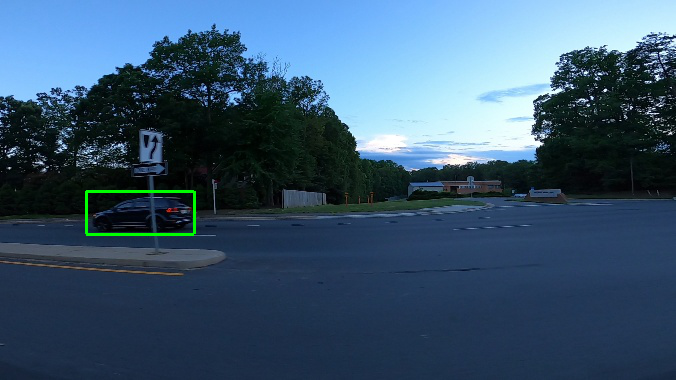

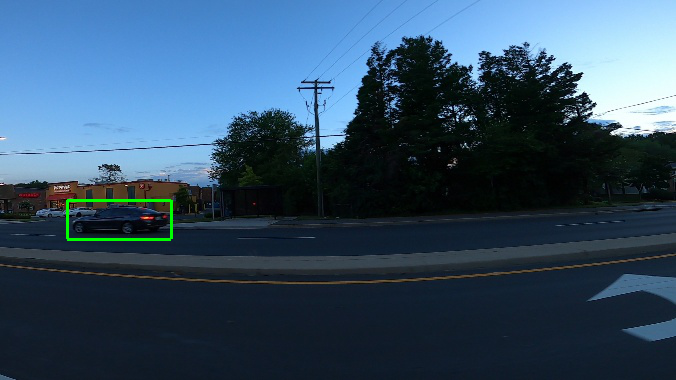

In [ ]:
#Below examples of images with boxes in training dataset
for i in range(2):
    idx = random.randrange(len(training_list))
    training_list[idx].draw_image_with_boxes()

In [ ]:
#put all inputs and outputs to tensors without any data loaders or generators
#Do this only if enough memory is available
train_X = np.concatenate([x.get_inputs() for x in training_list],axis=0)
train_y = np.concatenate([x.get_answer() for x in training_list],axis=0)

In [ ]:
#use pretrained MobileNet architecture with additional convolution layer 
#which split data to 2 classes - car and background. 
#Pretrained layers not locked (personal choice, can be changed)

def build_model():
    mobilenet = MobileNetV2(weights='imagenet',include_top=False)
    x = mobilenet.outputs[0]
    x = Conv2D(2,1)(x)
    model = Model(mobilenet.inputs,x)
    model.compile('adam',loss = 'mse')
    return model

In [ ]:
#build model and view model summary
model = build_model()
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
_______________________________

In [ ]:
#training the model
model.fit(train_X,train_y,epochs=4)

Epoch 1/4
12/12 [==============================] - 318s 26s/step - loss: 1.3961 - accuracy: 0.8592
Epoch 2/4
12/12 [==============================] - 309s 26s/step - loss: 0.1946 - accuracy: 0.9795
Epoch 3/4
12/12 [==============================] - 307s 25s/step - loss: 0.1005 - accuracy: 0.9862
Epoch 4/4
12/12 [==============================] - 307s 25s/step - loss: 0.0743 - accuracy: 0.9878


In [ ]:
#saving complete model
model.save('model')

INFO:tensorflow:Assets written to: model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!zip -r /content/car-object-detection.zip car_detection
!rm -rv car_detection

	zip warning: name not matched: car_detection

zip error: Nothing to do! (try: zip -r /content/car-object-detection.zip . -i car_detection)
rm: cannot remove 'car_detection': No such file or directory


In [ ]:
#model wrapper for inference
model_wrapper = KerasModelWrapper(model)

In [ ]:
def load_test_images(path):
    cases = []
    for filename in os.listdir(path):
        file_path = path + '/' + filename
        case = TrainingCase(file_path)
        cases.append(case)
    
    return cases

In [ ]:
def populate_boxes(model,case):
    prediction = model.predict(case)
    mask = prediction[2].copy()
    h,w = mask.shape
    boxes = []
    
    def walk_on_box(sx,sy):
        box = DetectionBox(sx,sy,sx,sy)
        q = Queue()
        q.put((sx,sy))
        while not q.empty():
            x,y = q.get()
            box.resize_to_point(x+1,y+1)
            mask[y,x] = False
            if y+1 < h and mask[y+1,x]:
                q.put((x,y+1))
            if y-1 >= 0 and mask[y-1,x]:
                q.put((x,y-1))
            if x+1 < w and mask[y,x+1]:
                q.put((x+1,y))
            if x-1 >= 0 and mask[y,x-1]:
                q.put((x-1,y))
        
        return box.scale(32)
    
    for y in range(h):
        for x in range(w):
            if mask[y,x]:
                boxes.append(walk_on_box(x,y))
    
    case.boxes = boxes

In [ ]:
testing_list = load_test_images(testing_dataset_images_path)
for case in testing_list:
    populate_boxes(model_wrapper,case)

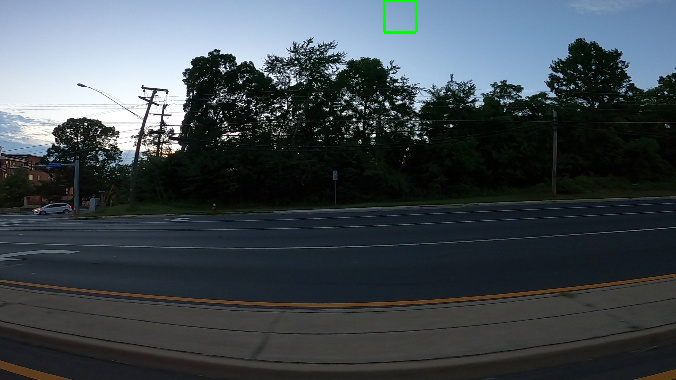

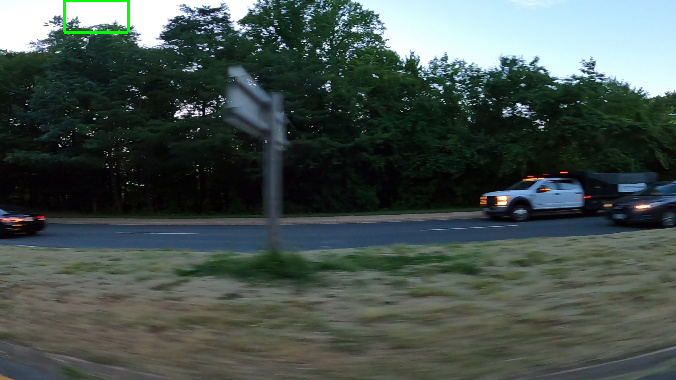

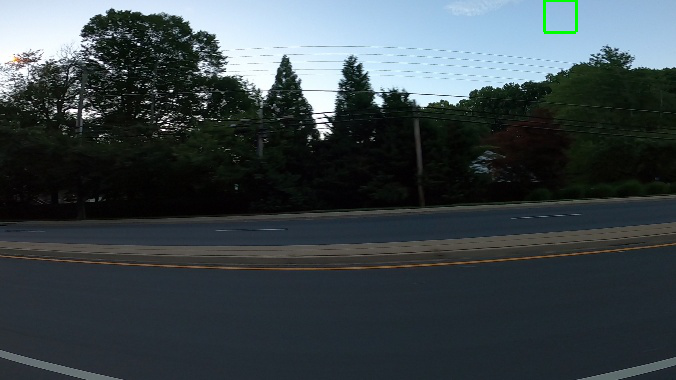

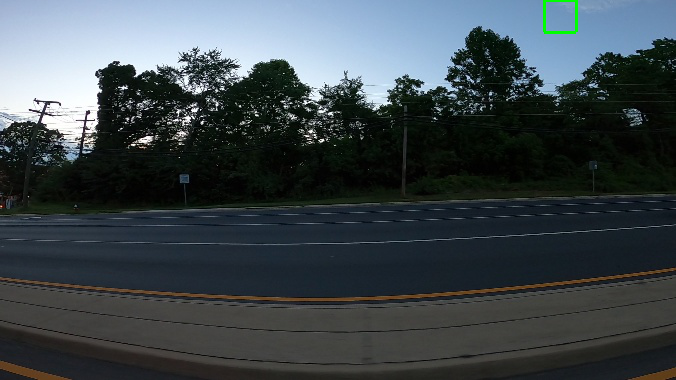

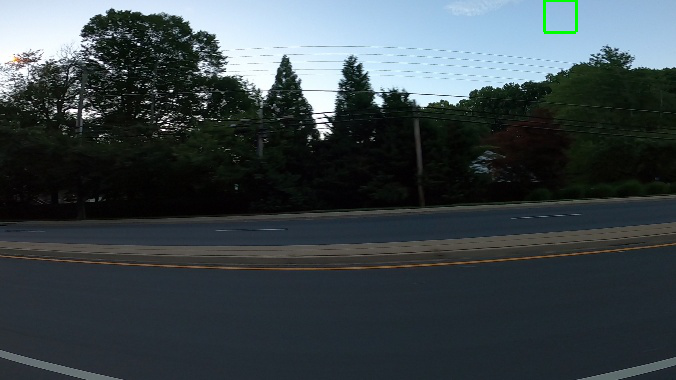

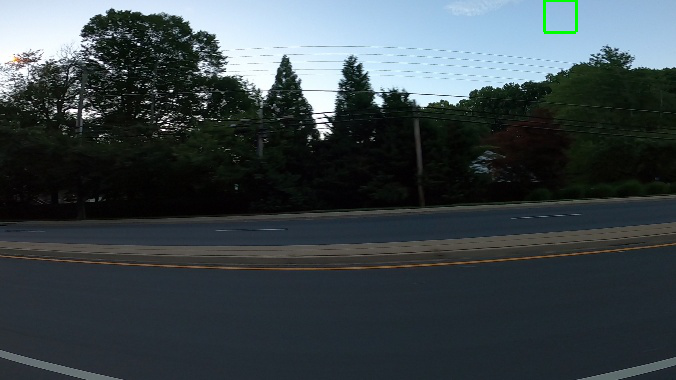

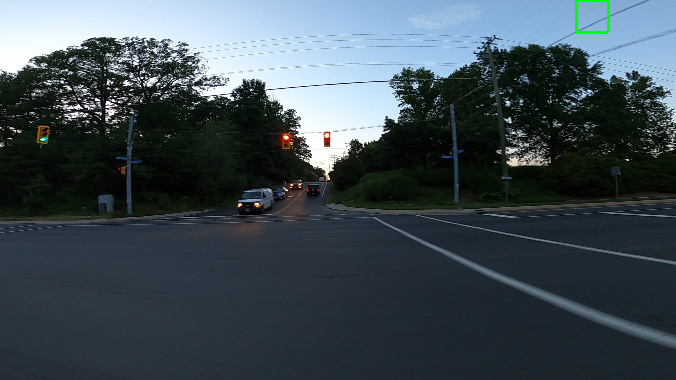

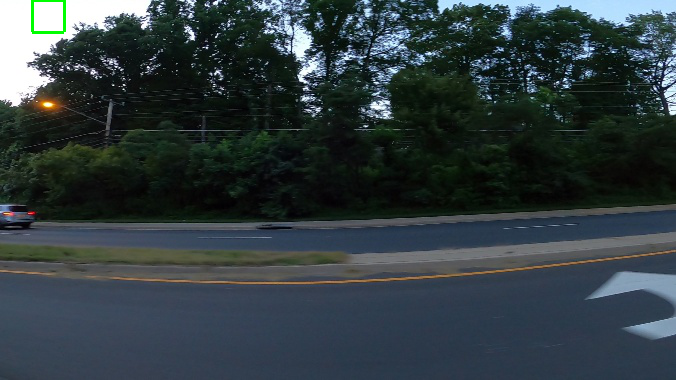

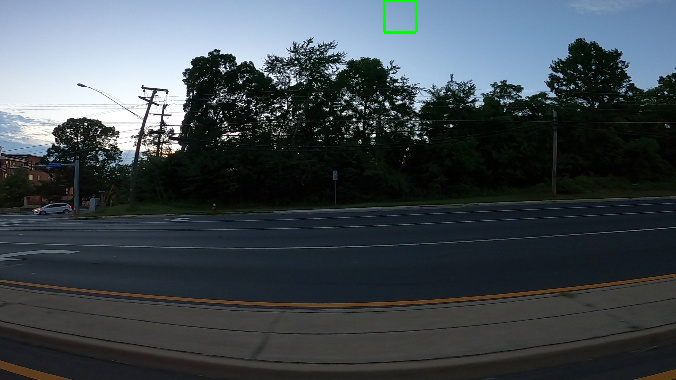

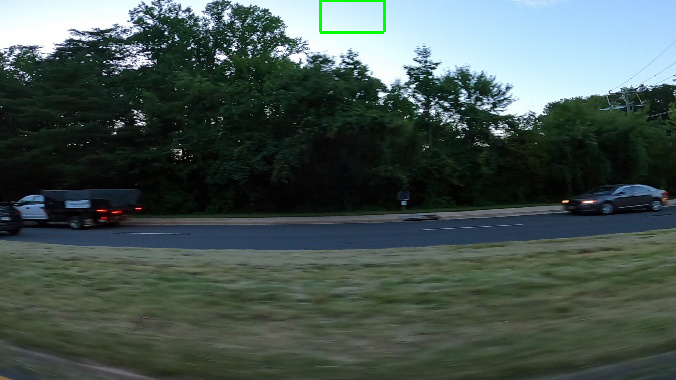

In [ ]:
for i in range(10):
    idx = random.randrange(len(testing_list))
    while len(testing_list[idx].boxes) == 0:
        idx = random.randrange(len(testing_list))
    testing_list[idx].draw_image_with_boxes()

In [ ]:
# !pip install pytube

In [ ]:
# from pytube import YouTube

# vid = input("Enter youtube link that you want to use")
# yt = YouTube(vid)

In [ ]:
# yt.thumbnail_url

In [ ]:
# yt.streams.all()

In [ ]:
# stream = yt.streams.first()
# stream

In [ ]:
# stream.download()

In [ ]:
# import cv2
# from matplotlib import pyplot as plt
# %matplotlib inline

# cap = cv2.VideoCapture('/content/test.3gpp')
 
# while(cap.isOpened()):
#     try:
#         # read frame
#         ret, frame = cap.read()
#         frame = tf.reshape(frame,(-1,frame.shape[0],frame.shape[1],frame.shape[2]))
#         pred = model.predict(frame)
        
#         # IPython.display.clear_output(wait=True)
 
#         plt.imshow(pred)
#         plt.title("Video Inference")
#         plt.axis("off")
#         plt.show()
 
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#           break
 
#     except KeyboardInterrupt:
#         cap.release()
#         print("Video stopped.")
#         break
        
# cap.release()
# cv2.destroyAllWindows()